In [3]:
import pandas as pd

csv = pd.read_csv('train_data_add.csv')
titles_csv = csv['title']
prices_csv = csv['price']

In [2]:
import pickle
from konlpy.tag import Okt
import random

try:
    with open("titles_words.bin", "rb") as f:
        titles_words = pickle.load(f)
    with open("dictionary.bin", "rb") as f:
        dictionary = pickle.load(f)
    with open("titles_ids.bin", "rb") as f:
        titles_ids = pickle.load(f)
        
except Exception as e:
    okt = Okt()
    words_set = set()
    titles_words = []
    count = 1
    for title in titles_csv:
        title_pos = okt.pos(title, norm=True)
        words = []
        for word in title_pos:
            words_set.add(word[0])
            words.append(word[0])
        titles_words.append(words)
        count += 1
        
    dictionary = list(words_set)
    random.shuffle(dictionary)
    dictionary = [0] + dictionary
    titles_ids = []
    count = 1
    for title in titles_words:
        words_id = []
        for words in title:
            words_id.append(dictionary.index(words))
        titles_ids.append(words_id)
        count += 1
        
    with open("titles_words.bin", "wb") as f:
        pickle.dump(titles_words, f)
    with open("dictionary.bin", "wb") as f:
        pickle.dump(dictionary, f)
    with open("titles_ids.bin", "wb") as f:
        pickle.dump(titles_ids, f)

In [3]:
len(dictionary)

6875

In [4]:
def ids_to_words(ids):
    words = []
    for word_id in ids:
        words.append(dictionary[word_id])
    return words

In [5]:
print(titles_words[0])
print(titles_ids[0])
print(ids_to_words(titles_ids[0]))

['갤럭시', 'j', '7']
[5889, 412, 1822]
['갤럭시', 'j', '7']


In [6]:
max_title_len = max(len(title_ids) for title_ids in titles_ids)
print(max_title_len)

29


In [7]:
from keras.preprocessing import sequence
import numpy as np

titles_ids_np = sequence.pad_sequences(titles_ids, maxlen=max_title_len, padding='post')
print(titles_ids_np)

prices_np = np.array([[price] for price in prices_csv])
print(prices_np)

Using TensorFlow backend.


[[5889  412 1822 ...    0    0    0]
 [3378 3607    0 ...    0    0    0]
 [4263 5993 6799 ...    0    0    0]
 ...
 [4676 4527 2466 ...    0    0    0]
 [5889 1887  391 ...    0    0    0]
 [5889 1887  391 ...    0    0    0]]
[[  50000]
 [  50000]
 [  50000]
 ...
 [3100000]
 [3950000]
 [3950000]]


In [8]:
import random

index = [i for i in range(len(titles_ids_np))]
random.shuffle(index)

train_len = int(len(index) * 0.9)
train_index = index[:train_len]
test_index = index[train_len:]

print(len(titles_ids_np))
print(len(train_index))
print(len(test_index))

47227
42504
4723


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

X_train = titles_ids_np[train_index]
X_test = titles_ids_np[test_index]

scaler = MinMaxScaler()  # StandardScaler()
scaler.fit(prices_np)
y_scaled = scaler.transform(prices_np)

y_train_scaled = y_scaled[train_index]
y_test_scaled = y_scaled[test_index]

print(prices_np)
print(y_scaled)

[[  50000]
 [  50000]
 [  50000]
 ...
 [3100000]
 [3950000]
 [3950000]]
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.78205128]
 [1.        ]
 [1.        ]]


## Model Parameter Tunning
#### 1. Epoch 변경
#### 2. Activation 변경
#### 3. Optimizer 변경
#### 4. Dropout layer 추가 및 변경
#### 5. GRU, LSTM layer 추가 및 변경 (, return_sequences=True 변경)
#### 6. Embed size 수정

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import models

vocab_size = len(dictionary)
model = keras.Sequential([
    layers.Embedding(vocab_size, 64),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])
model.summary()

model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.Adam(1e-4), metrics=['mae'])

model_name = "baseline_model.h5"
try:
    model = models.load_model(model_name)
except Exception as e:
    print(e)
    history = model.fit(X_train, y_train_scaled, epochs=10, validation_data=(X_test, y_test_scaled), validation_steps=30, verbose=1)
    model.save(model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          440000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 551,489
Trainable params: 551,489
Non-trainable params: 0
__________________________________________________

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

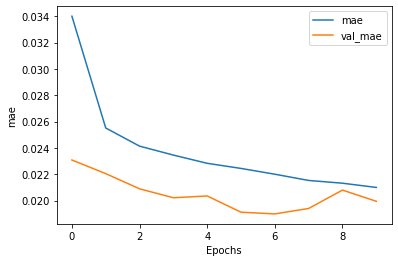

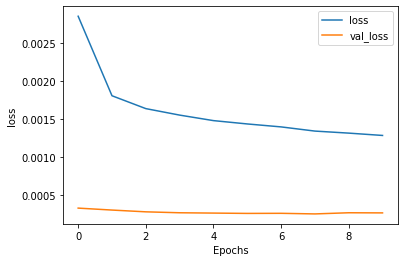

In [12]:
plot_graphs(history, 'mae')
plot_graphs(history, 'loss')

In [17]:
price_predictions = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test_scaled)
price_predictions_inverse = scaler.inverse_transform(price_predictions)

for i in range(100):
    print(f"{i}: {y_test_inverse[i]} = {price_predictions_inverse[i]}")

0: [100000.] = [113193.65]
1: [280000.] = [325458.34]
2: [110000.] = [141241.22]
3: [65000.] = [64213.387]
4: [780000.] = [605617.06]
5: [88000.] = [518482.3]
6: [940000.] = [906923.8]
7: [279000.] = [270836.22]
8: [450000.] = [452102.44]
9: [160000.] = [173367.17]
10: [200000.] = [127701.53]
11: [550000.] = [561028.4]
12: [100000.] = [131379.84]
13: [670000.] = [670197.9]
14: [650000.] = [603371.06]
15: [1050000.] = [979257.56]
16: [250000.] = [288982.1]
17: [660000.] = [532334.25]
18: [550000.] = [535692.5]
19: [600000.] = [643626.44]
20: [550000.] = [342998.72]
21: [850000.] = [748050.7]
22: [640000.] = [428419.16]
23: [200000.] = [194555.]
24: [297000.] = [231614.27]
25: [341500.] = [358658.9]
26: [109000.] = [157073.73]
27: [270000.] = [149671.81]
28: [150000.] = [171863.27]
29: [100000.] = [151793.75]
30: [80000.] = [108120.03]
31: [540000.] = [407356.2]
32: [70000.] = [157599.34]
33: [280000.] = [292343.2]
34: [750000.] = [647836.25]
35: [1270000.] = [1201066.2]
36: [80000.] = [

In [19]:
ids_to_words(X_test[5])

['KT',
 '갤럭시',
 'Z',
 '플립',
 '(',
 'F',
 '700',
 'N',
 ')',
 '퍼플',
 '256',
 '기',
 '가',
 '(',
 '0292512',
 ')',
 '판매',
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]